In [36]:
import theano
import lasagne
import pandas as pd
import numpy as np

from nltk.corpus import stopwords

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from nolearn.lasagne import NeuralNet
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import BatchIterator
from lasagne.layers import InputLayer, Conv2DLayer, DropoutLayer,\
    MaxPool2DLayer, DenseLayer
from lasagne.nonlinearities import softmax, sigmoid
from sklearn.cross_validation import train_test_split

In [137]:
df = pd.read_csv('/home/leandro/Documentos/Universidad/DSS/dss_2016/TPFINAL/data/imdb.csv')

In [138]:
def agrupar_pelis(x):
    if x >=8:
        return 2
    elif x<8 and x>=6:
        return 1
    else:
        return 0

df['imdb_score'] = df['imdb_score'].apply(agrupar_pelis)

In [139]:
ratings = np.sort(df['imdb_score'].unique())

In [140]:
len(df[df.imdb_score == 0]), len(df[df.imdb_score == 1]),len(df[df.imdb_score == 2])

(1454, 3261, 328)

In [141]:
#df['earning_rate'] = df.apply(lambda r: r.gross / r.budget, axis=1)

In [142]:
a = df.corr()

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


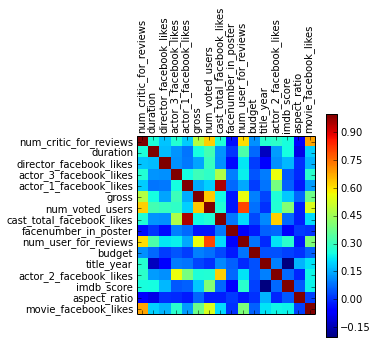

In [143]:
import matplotlib.pyplot as plt

df_corr = df[a.columns.tolist()]

plt.matshow(df_corr.corr())
plt.xticks(np.arange(0, len(df_corr.columns)), df_corr.columns.tolist(), rotation="vertical")
plt.yticks(np.arange(0, len(df_corr.columns)), df_corr.columns.tolist())
plt.colorbar()
plt.show()

In [144]:
ac1 = df['actor_1_name'].unique()
ac2 = df['actor_2_name'].unique()
ac3 = df['actor_3_name'].unique()

In [145]:
total = np.concatenate((ac1, ac2, ac3))

In [146]:
total = dict(enumerate(set(total)))

In [147]:
def factorizar(row):
    for x in total:
        if total[x] == row:
            return int(x)

In [148]:
df['actor_1_name'] = df['actor_1_name'].apply(lambda row: factorizar(row))
df['actor_2_name'] = df['actor_2_name'].apply(lambda row: factorizar(row))
df['actor_3_name'] = df['actor_3_name'].apply(lambda row: factorizar(row))

In [149]:
## Para obtener los indices de los paises y los lenguajes de las peliculas
idx_language, label_language = pd.factorize(df['language'])
idx_country, label_country = pd.factorize(df['country'])

## Para obtener los indices de los actores
#idx_actor1, label_actor1 = pd.factorize(df['actor_1_name'])
#idx_actor2, label_actor2 = pd.factorize(df['actor_2_name'])
#idx_actor3, label_actor3 = pd.factorize(df['actor_3_name'])

## Para obtener el indice del director
idx_director, label_director = pd.factorize(df['director_name'])

#Para obtener los indices del titulo de las peliculas y el content rating
idx_movie, label_movie = pd.factorize(df['movie_title'])
idx_content, label_content = pd.factorize(df['content_rating'])

In [150]:
## Separa los generos en columnas
df = pd.concat([df, df.genres.str.get_dummies(sep='|')], axis=1)

In [151]:
df_separados = pd.DataFrame()
df_separados = pd.concat([df_separados, df.plot_keywords.str.replace('|',' ')],axis=1)

stopw = set(stopwords.words('english')) 
corpus = []
for e in df_separados.values:
    if type(e[0]) is str:
        corpus.append(e[0])
corpus1 = " ".join(corpus)
corpus1 = corpus1.split(" ")

In [152]:
corpus1 = list(filter(lambda x: not x[0] in stopw, corpus1))
corpus1 = set(corpus1)

In [153]:
from sklearn.feature_extraction.text import TfidfVectorizer
vocabulary = corpus1
vect = TfidfVectorizer(sublinear_tf=True, max_df=2, analyzer='word', 
           stop_words=stopw, vocabulary=vocabulary)
vect.fit(corpus)
#print(dict(zip(vect.get_feature_names(), vect.idf_)))

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=2, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words={'on', 'that', 'ours', 'more', 'but', 'his', 'ain', 'ma', 'weren', 'each', 'for', 'i', 'having', 'me', 'has', 'over', 'and', 'are', 'does', 'our', 'its', 'did', 'through', 'against', 'up', 'shouldn', 'him', 'haven', 'to', 'she', 'than', 'just', 'these', 'yours', 'y', 'my', 'how', 'there',...', 'hasn', 'any', 'so', 'too', 'under', 'not', 'about', 'both', 'an', 'your', 'all', 'will', 'here'},
        strip_accents=None, sublinear_tf=True,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary={'chipmunk', 'panzer', 'narcotics', 'confinement', 'punching', 'poorhouse', 'collector', 'liquid', 'cross', 'prosthetic', 'friendly', 'katharine', 'lighthouse', 'crane'

In [154]:
def transformar_keywords(k):
    if not type(k) is str:
        return 0  
    keywords = k.replace('|'," ")
    doc_tfidf = vect.transform([k])
    t = doc_tfidf.toarray().sum()
    return t

In [155]:
df['plot_keywords'] = df['plot_keywords'].apply(lambda row: transformar_keywords(row)) 

In [156]:
df['language'] = idx_language
df['country'] = idx_country
#df['actor_1_name'] = idx_actor1
#df['actor_2_name'] = idx_actor2
#df['actor_3_name'] = idx_actor3
df['director_name'] = idx_director
df['movie_title'] = idx_movie
df['content_rating'] = idx_content

In [157]:
df.fillna(value=-1, inplace=True)

In [158]:
ys = df['imdb_score']
df.drop('imdb_score', axis=1, inplace=True)

### Columnas Dropeadas

In [159]:
df.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'aspect_ratio', 'movie_facebook_likes', 'Action', 'Adventure',
       'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Family', 'Fantasy', 'Film-Noir', 'Game-Show', 'History', 'Horror',
       'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance',
       'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western'],
      dtype='object')

In [160]:
#df.drop('actor_1_facebook_likes', axis=1, inplace=True)
#df.drop('actor_2_facebook_likes', axis=1, inplace=True)
#df.drop('actor_3_facebook_likes', axis=1, inplace=True)
#df.drop('director_facebook_likes', axis=1, inplace=True)

#df.drop('director_name', axis=1, inplace=True)
#df.drop('actor_1_name', axis=1, inplace=True)
#df.drop('actor_2_name', axis=1, inplace=True)
#df.drop('actor_3_name', axis=1, inplace=True)

#df.drop('cast_total_facebook_likes', axis=1, inplace=True)
#df.drop('movie_facebook_likes', axis=1, inplace=True)
#df.drop('budget', axis=1, inplace=True)
#df.drop('gross', axis=1, inplace=True)
#df.drop('cast_total_facebook_likes', axis=1, inplace=True)
#df.drop('plot_keywords', axis=1, inplace=True)
df.drop('genres', axis=1, inplace=True)
df.drop('movie_imdb_link', axis=1, inplace=True)
df.drop('color', axis=1, inplace=True)
#df.drop('num_user_for_reviews', axis=1, inplace=True)
#df.drop('movie_title', axis=1, inplace=True)
#df.drop('content_rating', axis=1, inplace=True)
#df.drop('duration', axis=1, inplace=True)

In [161]:
xs = df.values

In [162]:
std_x = MinMaxScaler([-1,1])
xs = std_x.fit_transform(xs)
std_y = MinMaxScaler([-1,1])
ys = std_y.fit_transform(ys)

/home/leandro/virtualenvs/DSS/lib/python3.4/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/leandro/virtualenvs/DSS/lib/python3.4/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/leandro/virtualenvs/DSS/lib/python3.4/site-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


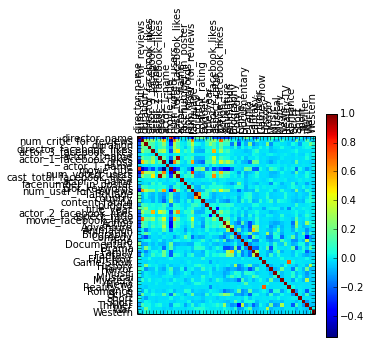

In [163]:
a = df.corr()

df_corr = df[a.columns.tolist()]

plt.matshow(df_corr.corr())
plt.xticks(np.arange(0, len(df_corr.columns)), df_corr.columns.tolist(), rotation="vertical")
plt.yticks(np.arange(0, len(df_corr.columns)), df_corr.columns.tolist())
plt.colorbar()
plt.show()

# PCA

In [164]:
from sklearn.decomposition import RandomizedPCA # using randomized Singular Value Decomposition 
Xp = RandomizedPCA(n_components=35, random_state=1)
Xp = Xp.fit_transform(xs)

#std_x = MinMaxScaler([-1,1])
#xs = std_x.fit_transform(Xp)
#std_y = MinMaxScaler([-1,1])
#ys = std_y.fit_transform(ys)

In [165]:
#Xp.explained_variance_ratio_.cumsum()

In [166]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(xs, ys,random_state=1)

In [167]:
y_train

array([ 0., -1.,  1., ...,  0.,  0.,  0.])

             precision    recall  f1-score   support

       -1.0       0.61      0.79      0.69       296
        0.0       0.91      0.78      0.84       930
        1.0       0.35      0.86      0.50        35

avg / total       0.83      0.79      0.80      1261

Score over Testing Data 0.7866772402854877
Score over Training Data 1.0


/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


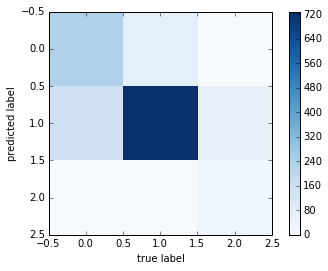

In [168]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics


def plot_matrix(clf, X_test, y_test):
    plt.clf()
    plt.imshow(confusion_matrix(clf.predict(X_test), y_test),
               interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    plt.xlabel("true label")
    plt.ylabel("predicted label")
    plt.show()

clf = ExtraTreesClassifier(n_estimators=300,
                           max_features=0.2, 
                           n_jobs=2,
                           max_depth=None,
                           min_samples_split=1,
                           random_state=1).fit(X_train, y_train)
print(classification_report(clf.predict(X_test), y_test))
print("Score over Testing Data {}".format(clf.score(X_test, y_test)))
print("Score over Training Data {}".format(clf.score(X_train, y_train)))
plot_matrix(clf, X_test, y_test)

In [169]:
clf.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=0.2, max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=1,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=2,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

(50,)


(0, 50)

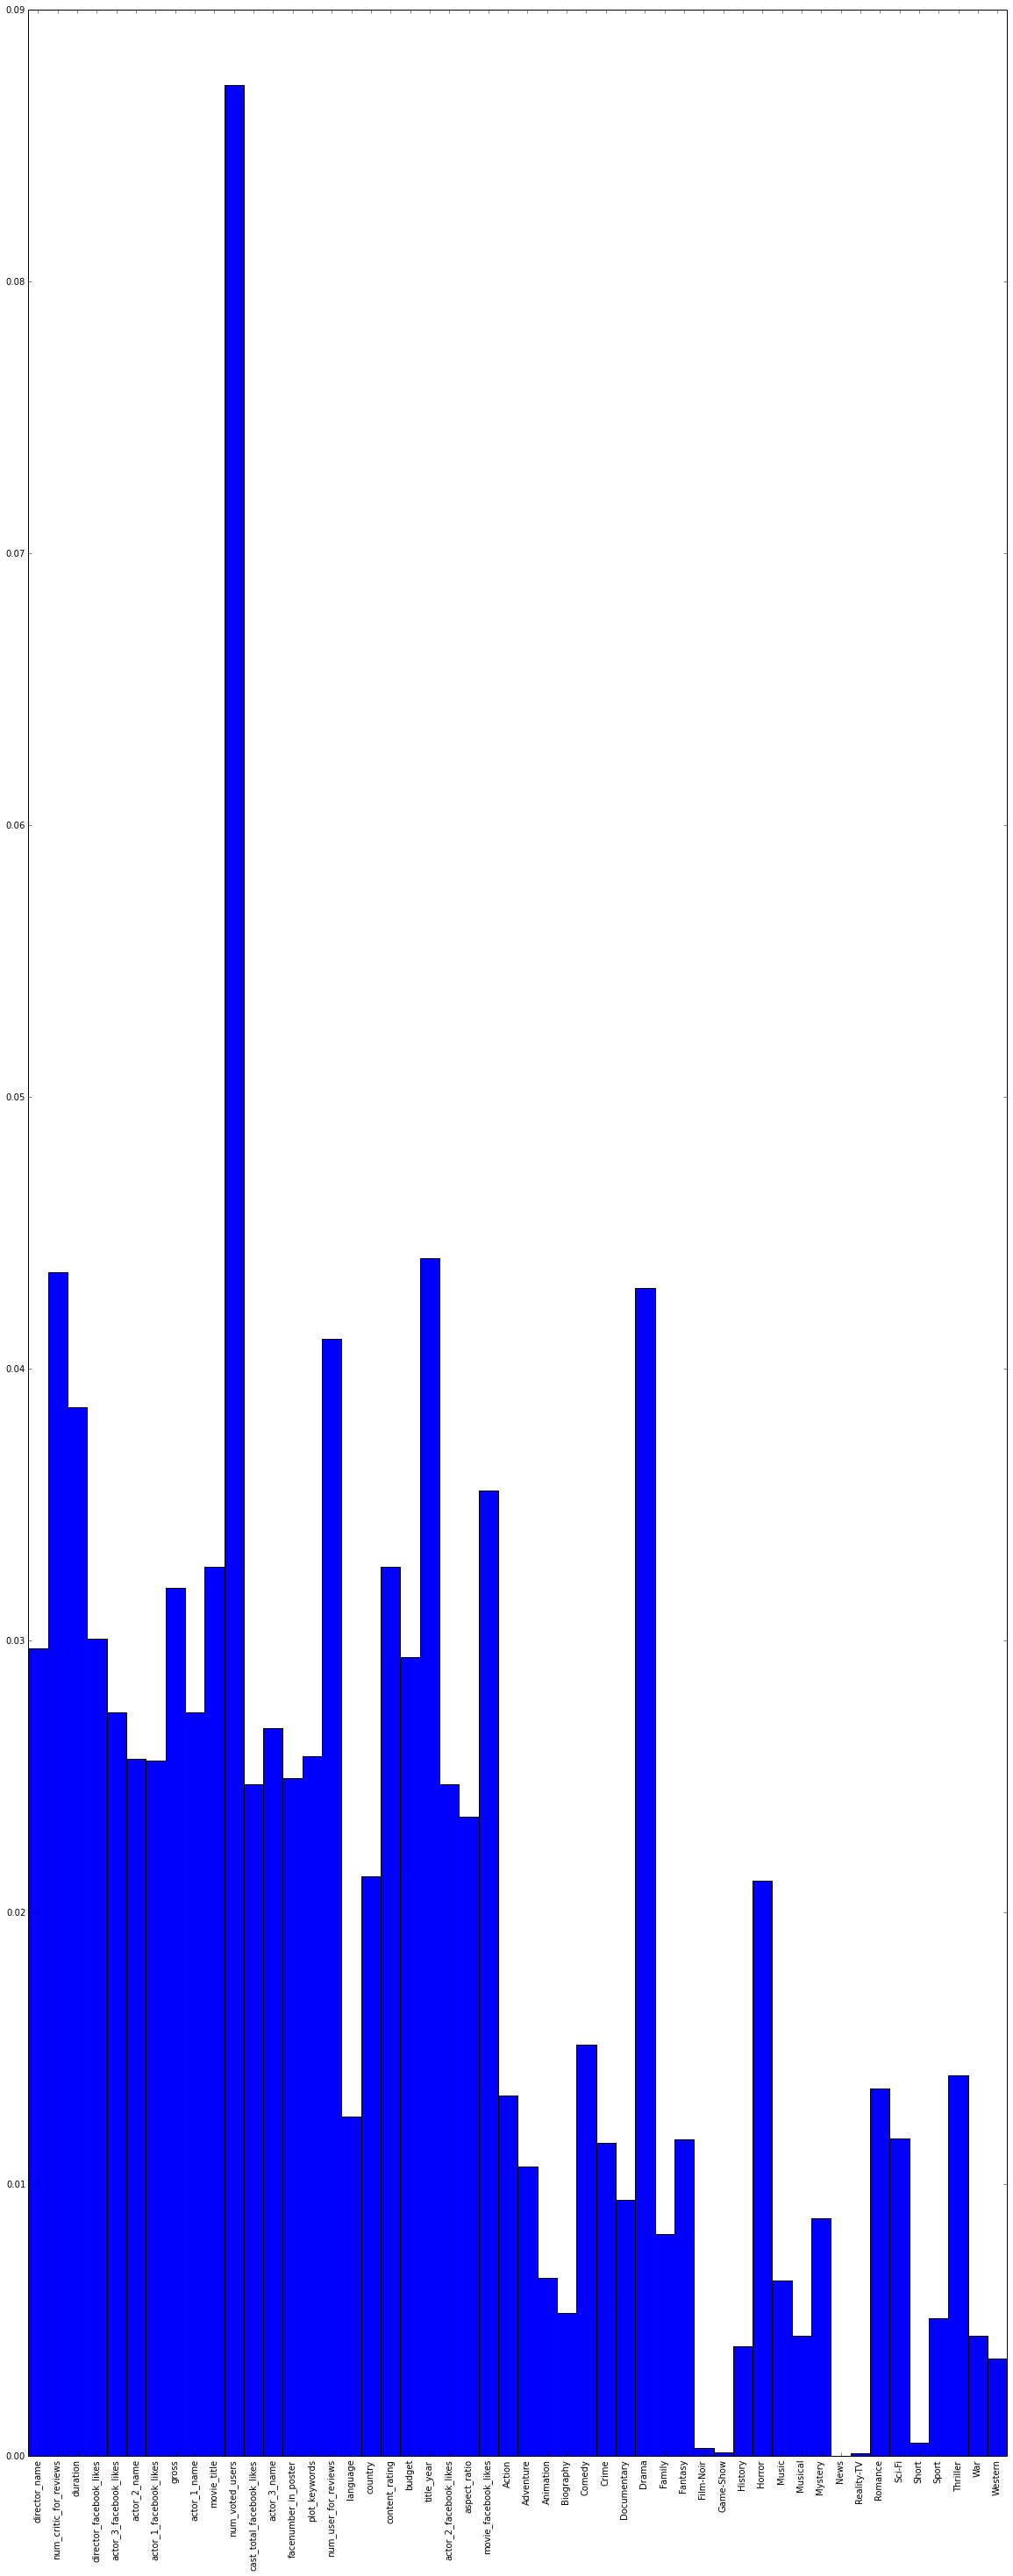

In [170]:
importances = clf.feature_importances_
cols = len(df.columns)

text = list(map(lambda i: df.columns[i], range(cols)))
plt.figure(figsize=(20,cols))
print(importances[::-1].shape)
plt.bar(range(cols),height=importances,  width=1.)
plt.xticks(np.arange(0.5, cols, 1.), text, rotation=90)
plt.xlim((0, cols))
#plt.show()

In [171]:
confusion_matrix(clf.predict(X_test), y_test)

array([[233,  63,   0],
       [146, 729,  55],
       [  0,   5,  30]])

## Dummy

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


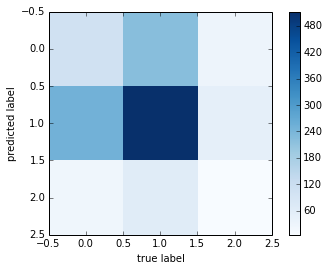

             precision    recall  f1-score   support

       -1.0       0.28      0.30      0.29       357
        0.0       0.64      0.63      0.64       811
        1.0       0.06      0.05      0.06        93

avg / total       0.50      0.49      0.50      1261



In [172]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier(random_state=0).fit(X_train, y_train)
#print clf.score(X_test, y_test)
plot_matrix(clf, X_test, y_test)
clf.score(X_test, y_test)
print(classification_report(clf.predict(X_test), y_test))

## SVM

             precision    recall  f1-score   support

       -1.0       0.39      0.74      0.51       201
        0.0       0.93      0.71      0.80      1055
        1.0       0.06      1.00      0.11         5

avg / total       0.84      0.71      0.76      1261

0.712926249009


/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


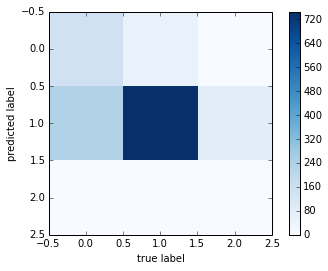

In [173]:
from sklearn.svm import SVC

sv = SVC(kernel='rbf', cache_size=1000)
sv.fit(X_train, y_train)

print(classification_report(sv.predict(X_test), y_test))
print(sv.score(X_test, y_test))
plot_matrix(sv, X_test, y_test)

# Red Neuronal

In [174]:
from lasagne.nonlinearities import linear, tanh

In [175]:
layers_0 = [
                (InputLayer, {'shape': (None, 50)}),
                (DenseLayer, {'num_units': 1024}),
                (DropoutLayer, {'p': 0.3}),
                (DenseLayer, {'num_units': 1024}),
                (DenseLayer, {'num_units': 2, 'nonlinearity': sigmoid}),
        ]

In [176]:
class AdjustVariable(object):
    """
    Used to decreases linearly the learning rate with the number of epochs,
    while we the momentum increase.
    """
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = np.float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)

In [177]:
def create_network(npochs=50, batch_s=10000):
    return NeuralNet(
        layers=layers_0,
        update=nesterov_momentum,
        update_learning_rate=theano.shared(np.float32(0.003)),
        update_momentum=theano.shared(np.float32(0.9)),

        regression=False,
        batch_iterator_train=BatchIterator(batch_size=batch_s),
        on_epoch_finished=[
            AdjustVariable('update_learning_rate', start=0.003, stop=0.0003),
            AdjustVariable('update_momentum', start=0.9, stop=0.9999)
        ],
        max_epochs=npochs,
        verbose=1)

net0 = create_network(150)

In [178]:
#theano.config.profile = True


In [179]:
y_train = y_train.astype(np.int32)
X_train = X_train.astype(np.float32)

net0.fit(X_train, y_train)

# Neural Network with 1103874 learnable parameters

## Layer information

  #  name        size
---  --------  ------
  0  input0        50
  1  dense1      1024
  2  dropout2    1024
  3  dense3      1024
  4  dense4         2

  epoch    trn loss    val loss    trn/val    valid acc  dur
-------  ----------  ----------  ---------  -----------  -----
      1     0.67240     0.63642    1.05654      0.40951  0.77s
      2     0.63346     0.58518    1.08250      0.52840  0.77s
      3     0.58287     0.52716    1.10566      0.60634  0.76s
      4     0.52504     0.46684    1.12468      0.64333  0.77s
      5     0.46882     0.40771    1.14988      0.64993  1.02s
      6     0.40889     0.35228    1.16069      0.64993  0.89s
      7     0.35366     0.30201    1.17102      0.65125  0.80s
      8     0.30411     0.25754    1.18085      0.65125  0.82s
      9     0.26016     0.21893    1.18834      0.65125  0.83s
     10     0.22183     0.18585    1.19360      0.65125  0.87s
     11     0.188

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7fbfab6f5c50>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7fbf7e8fdb00>,
     check_input=True, custom_scores=None,
     layers=[(<class 'lasagne.layers.input.InputLayer'>, {'shape': (None, 50)}), (<class 'lasagne.layers.dense.DenseLayer'>, {'num_units': 1024}), (<class 'lasagne.layers.noise.DropoutLayer'>, {'p': 0.3}), (<class 'lasagne.layers.dense.DenseLayer'>, {'num_units': 1024}), (<class 'lasagne.layers.dense.DenseLayer'>, {'nonlinearity': <function sigmoid at 0x7fbfb521d1e0>, 'num_units': 2})],
     loss=None, max_epochs=150, more_params={},
     objective=<function objective at 0x7fbfab6fc598>,
     objective_loss_function=<function categorical_crossentropy at 0x7fbfb5229bf8>,
     on_batch_finished=[],
     on_epoch_finished=[<__main__.AdjustVariable object at 0x7fbf7e8fdc88>, <__main__.AdjustVariable object at 0x7fbf7e004c18>, <nolearn.lasagne.h

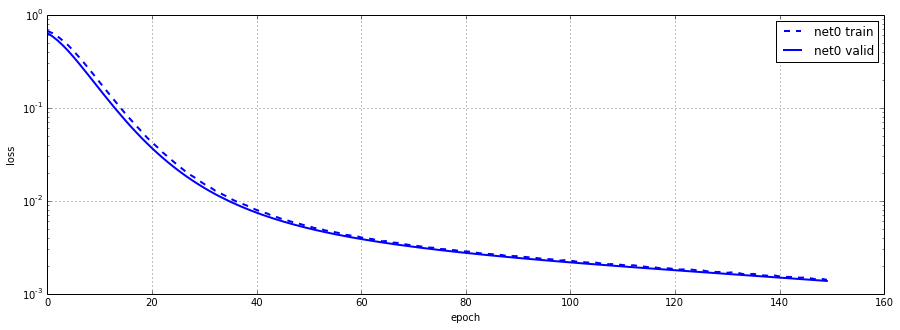

In [180]:
%matplotlib inline

plt.clf()
plt.figure(figsize=(15,5))

train_loss = np.array([i["train_loss"] for i in net0.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net0.train_history_])
plt.plot(train_loss, '--b', linewidth=2, label="{} train".format("net0"))
plt.plot(valid_loss, '-b', linewidth=2, label="{} valid".format("net0"))

plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")
plt.show()

/home/leandro/virtualenvs/DSS/lib/python3.4/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


             precision    recall  f1-score   support

         -1       0.00      0.00      0.00         0
          0       1.00      0.63      0.77      1261
          1       0.00      0.00      0.00         0

avg / total       1.00      0.63      0.77      1261



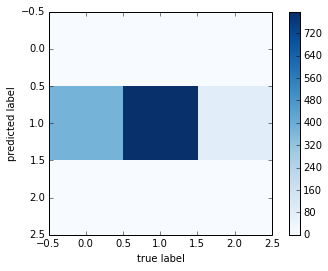

In [181]:
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.int32)

print(classification_report(net0.predict(X_test), y_test))
plot_matrix(net0, X_test, y_test)

# <span style="color:red"> VER ESTO!! NO ESTA TOMANDO LOS ELEMENTOS DE LAS CLASES 0 Y 2</span>.

In [182]:
confusion_matrix(net0.predict(X_test), y_test)

array([[  0,   0,   0],
       [379, 797,  85],
       [  0,   0,   0]])